In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.datasets import make_blobs
from pyspark import SparkContext
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler
from pyspark.sql import SQLContext
from pyspark.ml.evaluation import ClusteringEvaluator

In [6]:
n_samples=10000
n_features=3
X, y = make_blobs(n_samples=n_samples, centers=10, n_features=n_features, random_state=42)

# add a row index as a string
pddf = pd.DataFrame(X, columns=['x', 'y', 'z'])
pddf['id'] = 'row'+pddf.index.astype(str)

#move it first (left)
cols = list(pddf)
cols.insert(0, cols.pop(cols.index('id')))
pddf = pddf.loc[:, cols]
pddf.head()

# save the ndarray as a csv file
pddf.to_csv('input.csv', index=False)

<ipython-input-55-546d8abd576b>:1: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  threedee = plt.figure(figsize=(12,10)).gca(projection='3d')


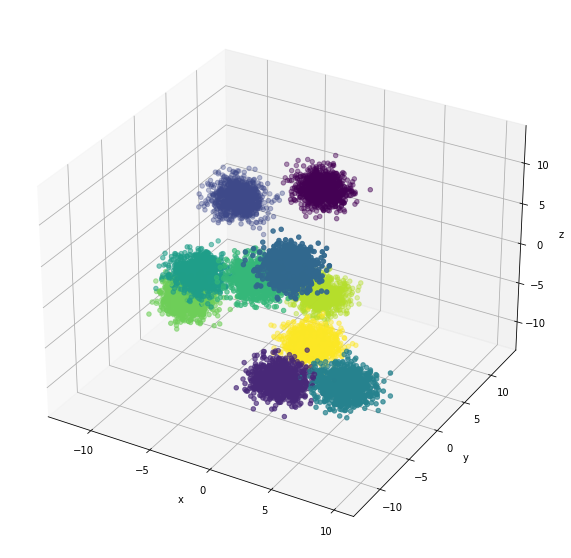

In [55]:
threedee = plt.figure(figsize=(12,10)).gca(projection='3d')
threedee.scatter(X[:,0], X[:,1], X[:,2], c=y)
threedee.set_xlabel('x')
threedee.set_ylabel('y')
threedee.set_zlabel('z')
plt.show()


In [102]:
FEATURES_COL = ['x', 'y', 'z']
path = 'input.csv'
df = spark.read.csv(path, header=True) # requires spark 2.0
for col in df.columns:
    if col in FEATURES_COL:
        df = df.withColumn(col,df[col].cast('float'))
df = df.na.drop()
df.show()

+-----+------------+----------+----------+
|   id|           x|         y|         z|
+-----+------------+----------+----------+
| row0|  -6.0776997|-2.9096103|-1.5181729|
| row1|  -1.0122601|  7.322841|-5.4424076|
| row2|   -8.297007| 6.3228936| 1.1672047|
| row3|  -3.5071216|  4.784812|-5.4449472|
| row4|   -5.122823|-3.3220499|-0.5069805|
| row5|  -2.4764006|  8.255791|  4.409478|
| row6|   7.3153954| -5.079449| -7.291215|
| row7|  -2.0167463|  9.303454|  7.095179|
| row8|  -0.2338185| -4.892681| 2.1228876|
| row9|    6.565442| -6.855994|-6.7983212|
|row10|  -5.6902847|-6.4827404|-0.9246967|
|row11|-0.017986143| 2.7632365| -8.814824|
|row12|  -6.9042625|-6.1491723|-3.5354295|
|row13|  -10.389865|  9.537853|  0.674591|
|row14|   3.9688683|-6.0467844| -5.462389|
|row15|   -7.337052|-3.7689247| -5.261122|
|row16|   -8.991589|  8.738728|  3.864116|
|row17| -0.18098584|  5.482743| -4.900118|
|row18|   3.3193955|-6.3573766| -6.978025|
|row19|  -2.0266335|-3.4171724|0.48218703|
+-----+----

In [16]:
vecAssembler = VectorAssembler(inputCols=FEATURES_COL, outputCol="features")
df_kmeans = vecAssembler.transform(df).select('id', 'features')
df_kmeans.show()

+-----+--------------------+
|   id|            features|
+-----+--------------------+
| row0|[-6.0776996612548...|
| row1|[-1.0122600793838...|
| row2|[-8.2970066070556...|
| row3|[-3.5071215629577...|
| row4|[-5.1228232383728...|
| row5|[-2.4764006137847...|
| row6|[7.31539535522460...|
| row7|[-2.0167462825775...|
| row8|[-0.2338185012340...|
| row9|[6.56544208526611...|
|row10|[-5.6902847290039...|
|row11|[-0.0179861430078...|
|row12|[-6.9042625427246...|
|row13|[-10.389864921569...|
|row14|[3.96886825561523...|
|row15|[-7.3370518684387...|
|row16|[-8.9915885925292...|
|row17|[-0.1809858381748...|
|row18|[3.31939554214477...|
|row19|[-2.0266335010528...|
+-----+--------------------+
only showing top 20 rows



Text(0, 0.5, 'cost')

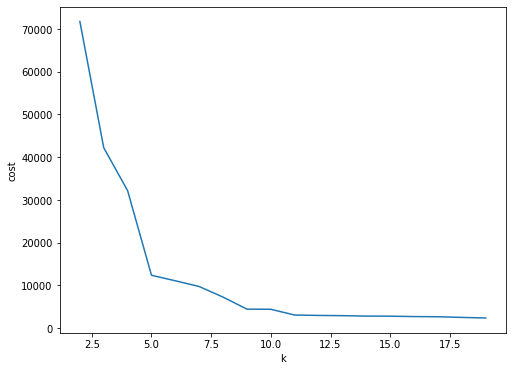

In [103]:
cost = np.zeros(20)
for k in range(2,20):
    kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol("features")
    model = kmeans.fit(df_kmeans.sample(False,0.1, seed=42))
    cost[k] = model.summary.trainingCost
fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,20),cost[2:20])
ax.set_xlabel('k')
ax.set_ylabel('cost')

In [104]:
k = 10
kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol("features")
model = kmeans.fit(df_kmeans)
df_pred = model.transform(df_kmeans).join(df,"id").select('id','x', 'y','z','prediction')
df_pred.show()

+-----+------------+----------+----------+----------+
|   id|           x|         y|         z|prediction|
+-----+------------+----------+----------+----------+
| row0|  -6.0776997|-2.9096103|-1.5181729|         2|
| row1|  -1.0122601|  7.322841|-5.4424076|         0|
| row2|   -8.297007| 6.3228936| 1.1672047|         3|
| row3|  -3.5071216|  4.784812|-5.4449472|         0|
| row4|   -5.122823|-3.3220499|-0.5069805|         9|
| row5|  -2.4764006|  8.255791|  4.409478|         5|
| row6|   7.3153954| -5.079449| -7.291215|         8|
| row7|  -2.0167463|  9.303454|  7.095179|         5|
| row8|  -0.2338185| -4.892681| 2.1228876|         6|
| row9|    6.565442| -6.855994|-6.7983212|         8|
|row10|  -5.6902847|-6.4827404|-0.9246967|         2|
|row11|-0.017986143| 2.7632365| -8.814824|         0|
|row12|  -6.9042625|-6.1491723|-3.5354295|         2|
|row13|  -10.389865|  9.537853|  0.674591|         3|
|row14|   3.9688683|-6.0467844| -5.462389|         4|
|row15|   -7.337052|-3.76892

<ipython-input-105-a47c8c2a7a32>:2: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  result = plt.figure(figsize=(12,10)).gca(projection='3d')


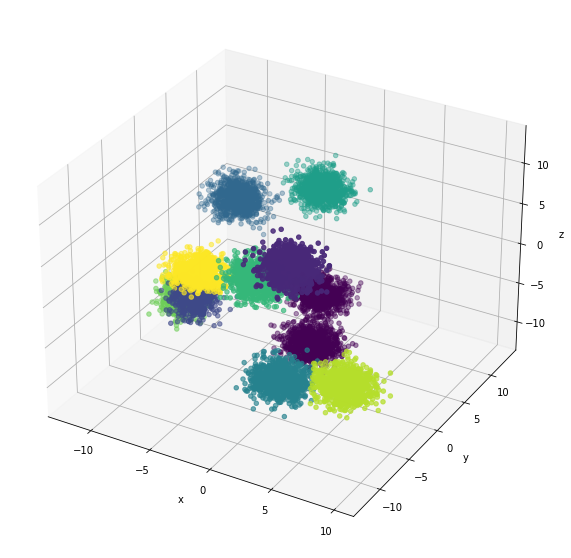

In [105]:
pddf_pred = df_pred.toPandas().set_index('id')
result = plt.figure(figsize=(12,10)).gca(projection='3d')
result.scatter(pddf_pred.x, pddf_pred.y, pddf_pred.z, c=pddf_pred.prediction)
result.set_xlabel('x')
result.set_ylabel('y')
result.set_zlabel('z')
plt.show()

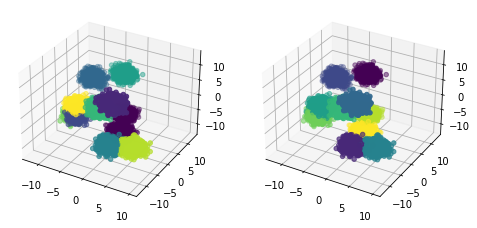

In [98]:
fig = plt.figure(figsize=plt.figaspect(0.5))
ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.scatter(pddf_pred.x, pddf_pred.y, pddf_pred.z, c=pddf_pred.prediction)
ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.scatter(X[:,0], X[:,1], X[:,2], c=y)

In [95]:
df_kmeans.sample(False,0.2, seed=42).count()

2088